In [2]:
# OASM
#02/11/2024
# DataSet analisis de sentimientos de productos de amazon 1-5
# En el data la pagina obtenida del dataset manejan los datos como
# 1-3 como negativas y 4-5 como positivos
# para tener un balanceo de 50 y 50, ya que actualmente esta 60-40
# podriamos aumentar el numero de comentarios similares en clasifcados como buenos
# esto en caso de que solo clasificquemos como bueno positivo o ngeativo en cawso contraario
#que tomemos cada nivel como una clase entonces no seria necesaria balancear los datos todos estan equilibradas.
# ESTA EN ESPAÑOL E INGLES LAS RESE{ÑAS}


import pandas as pd
#import numpy as np

import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import seaborn as sns
import warnings


warnings.filterwarnings('ignore')

data = pd.read_csv('https://raw.githubusercontent.com/ignaciomsarmiento/RecomSystemsLectures/main/L07_sentimientos/data/Amazon.csv', index_col="Unnamed: 0")

data.head()

,id,reviews.text,reviews.rating,reviews.text_esp
0,AVqVGWQDv8e3D1O-ldFr,This is a very nice tablet for my GF who has n...,5.0,Esta es una tableta muy agradable para mi novi...
1,AVqkIhwDv8e3D1O-lebb,Love this tablet. Easy to use. And price was r...,5.0,Me encanta esta tableta. Fácil de usar. Y el p...
2,AVphgVaX1cnluZ0-DR74,Affordable price awesome quality I love my Ama...,5.0,Precio asequible calidad increíble Me encanta ...
3,AVphgVaX1cnluZ0-DR74,I bought this after speaking with a sales rep ...,5.0,Compré esto después de hablar con un represent...
4,AVqVGWLKnnc1JgDc3jF1,Bought this tablet for my 2 &1/2 year old and ...,5.0,Compré esta tableta para mi hijo de 2 años y m...


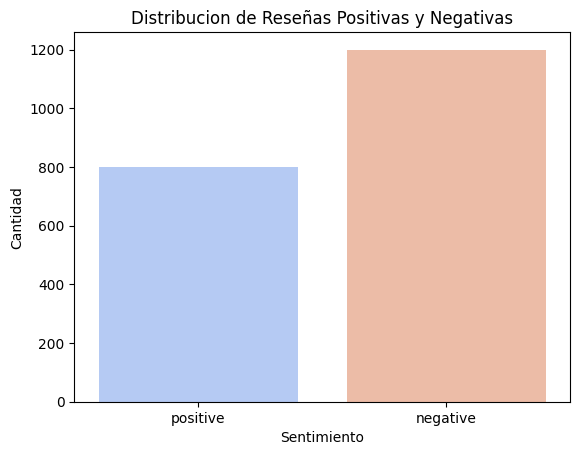

,id,reviews.text,reviews.rating,reviews.text_esp,sentiment,puntaje,sentimiento
0,AVqVGWQDv8e3D1O-ldFr,This is a very nice tablet for my GF who has n...,5.0,Esta es una tableta muy agradable para mi novi...,positive,1,POSITIVO
1,AVqkIhwDv8e3D1O-lebb,Love this tablet. Easy to use. And price was r...,5.0,Me encanta esta tableta. Fácil de usar. Y el p...,positive,1,POSITIVO
2,AVphgVaX1cnluZ0-DR74,Affordable price awesome quality I love my Ama...,5.0,Precio asequible calidad increíble Me encanta ...,positive,1,POSITIVO
3,AVphgVaX1cnluZ0-DR74,I bought this after speaking with a sales rep ...,5.0,Compré esto después de hablar con un represent...,positive,1,POSITIVO
4,AVqVGWLKnnc1JgDc3jF1,Bought this tablet for my 2 &1/2 year old and ...,5.0,Compré esta tableta para mi hijo de 2 años y m...,positive,1,POSITIVO


In [3]:
#print(data.columns)
data['sentiment'] = data['reviews.rating'].apply(lambda x: 'positive' if x >= 4 else 'negative')

#reseñas positivas y negativas
sns.countplot(x='sentiment', data=data, palette='coolwarm')
plt.title('Distribucion de Reseñas Positivas y Negativas')
plt.xlabel('Sentimiento')
plt.ylabel('Cantidad')
plt.show()

# mapear
puntaje = {
    1 : 0,
    2: 0,
    3: 0,
    4: 1,
    5: 1
}

sentimiento = {
    0: 'NEGATIVO',
    1: 'POSITIVO',
}

# MAPEANDO
data['puntaje'] = data['reviews.rating'].map(puntaje)
data['sentimiento'] = data['puntaje'].map(sentimiento)

data.head()

In [6]:

import string
import spacy
from num2words import num2words
import pandas as pd
import multiprocess as mp
import time

# Método para hacer nivelación de cargas
def nivelacion_cargas(D, n_p):
    s = len(D) % n_p
    n_D = D[:s]
    t = int((len(D) - s) / n_p)
    out = []
    temp = []
    for i in D[s:]:
        temp.append(i)
        if len(temp) == t:
            out.append(temp)
            temp = []
    for i in range(len(n_D)):
        out[i].append(n_D[i])
    return out

# Cargar el modelo de Spacy para español
nlp = spacy.load('es_core_news_sm')

# Agregar stop words adicionales
stop_words_adicionales = {"¡", "-", "—", "http", "<", ">"}
for palabra in stop_words_adicionales:
    nlp.Defaults.stop_words.add(palabra)

# Función para procesar el texto
def procesar_texto(texto):
    oraciones = texto.split('\n')
    total_oraciones = len(oraciones)
    oraciones_tokenizadas = []
    for oracion in oraciones:
        tokens = []
        doc = nlp(oracion)
        for token in doc:
            if token.is_digit:
                try:
                    numero = int(token.text)
                    palabra_letras = num2words(numero, lang='es')
                    tokens.append(palabra_letras)
                except ValueError:
                    pass
            else:
                lemma = token.text.lower()
                if lemma and lemma not in stop_words_adicionales:
                    tokens.append(lemma)
        oraciones_tokenizadas.append(" ".join(tokens))
    return total_oraciones, oraciones_tokenizadas

# Función para procesar los textos en paralelo
def procesar_textos_en_paralelo(particion):
    resultados = []
    for texto in particion:
        total_oraciones, oraciones_tokenizadas = procesar_texto(texto)
        resultados.append((total_oraciones, oraciones_tokenizadas))
    return resultados

if __name__ == '__main__':
    N_THREADS = 4  # Número de hilos

    # Cargar tus datos
    data = pd.read_csv('https://raw.githubusercontent.com/ignaciomsarmiento/RecomSystemsLectures/main/L07_sentimientos/data/Amazon.csv', index_col="Unnamed: 0")
    data = data[['reviews.text_esp', 'reviews.rating']]

    texto_dividido = nivelacion_cargas(data['reviews.text_esp'].tolist(), N_THREADS)


    start_time = time.perf_counter()

    with mp.Pool(N_THREADS) as pool:
        resultados = pool.map(procesar_textos_en_paralelo, texto_dividido)

    resultados_finales = [item for sublist in resultados for item in sublist]

    # Separar los resultados en columnas
    total_oraciones, oraciones_tokenizadas = zip(*resultados_finales)
    data['total_oraciones'] = total_oraciones
    data['oraciones_tokenizadas'] = oraciones_tokenizadas

    # Calcular tiempo total
    finish_time = time.perf_counter()
    print(f"Tiempo total de procesamiento: {finish_time - start_time:.2f} segundos")

    print(data[['reviews.text_esp', 'oraciones_tokenizadas', 'reviews.rating']].head())


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.4/119.4 kB 9.4 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/torch/__init__.py:1145: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at ../torch/csrc/tensor/python_tensor.cpp:432.)
  _C._set_default_tensor_type(t)


Tiempo total de procesamiento: 27.19 segundos
                                    reviews.text_esp  \
0  Esta es una tableta muy agradable para mi novi...   
1  Me encanta esta tableta. Fácil de usar. Y el p...   
2  Precio asequible calidad increíble Me encanta ...   
3  Compré esto después de hablar con un represent...   
4  Compré esta tableta para mi hijo de 2 años y m...   

                               oraciones_tokenizadas  reviews.rating  
0  [esta es una tableta muy agradable para mi nov...             5.0  
1  [me encanta esta tableta . fácil de usar . y e...             5.0  
2  [precio asequible calidad increíble me encanta...             5.0  
3  [compré esto después de hablar con un represen...             5.0  
4  [compré esta tableta para mi hijo de dos años ...             5.0  
